In [1]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import polytope as pc
import math
import pypoman

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.polytope import compute_polytope_volume, find_max_distance_to_polytope
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

In [ ]:
titlesize = 40
labelsize = 66
legendsize = 46
xticksize = 48
yticksize = xticksize
linewidth = 3
fontsize = 60
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [2]:
results = {'Ry13_Id': {'__0__': 3520, '__1__': 4672},
           'Ry13_Rx': {'__0__': 4033, '__1__': 4159},
           'Ry13_Ry': {'__0__': 1589, '__1__': 6603},
           'RyRz23_Id': {'__0__': 3593, '__1__': 4599},
           'RyRz23_Rx': {'__0__': 6834, '__1__': 1358},
           'RyRz23_Ry': {'__0__': 5488, '__1__': 2704},
           'RyRz43_Id': {'__0__': 3515, '__1__': 4677},
           'RyRz43_Rx': {'__0__': 2403, '__1__': 5789},
           'RyRz43_Ry': {'__0__': 6167, '__1__': 2025},
           'nothing_Id': {'__0__': 7473, '__1__': 719},
           'nothing_Rx': {'__0__': 4373, '__1__': 3819},
           'nothing_Ry': {'__0__': 4288, '__1__': 3904}}

In [3]:
POVM_base = np.array([
    [0.972, 0],
    [0, 0.093],
])

POVM_3 = [POVM_base, np.eye(2) - POVM_base]
POVM_2 = [qp.operator.RX(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]
POVM_1 = [qp.operator.RY(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]

POVM_3_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_3])
POVM_2_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_2])
POVM_1_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_1])

POVM_matrix = np.stack([POVM_1_matrix, POVM_2_matrix, POVM_3_matrix], axis=0)

In [7]:
ry = qp.operator.RY(np.arccos(-1 / 3)).as_channel()
rz23 = qp.operator.RZ(np.pi * 2 / 3).as_channel()
rz43 = qp.operator.RZ(np.pi * 4 / 3).as_channel()

state_1 = qp.Qobj([1, 0], True)
state_2 = ry.transform(state_1)
state_3 = rz23.transform(state_2)
state_4 = rz43.transform(state_2)

input_basis = [state_1, state_2, state_3, state_4]

In [4]:
def count_confidence(delta, frequencies, n_measurements):
    EPS = 1e-15
    freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
    KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                     + (1 - frequencies) * np.log(
                (1 - frequencies) / (1 - freq_plus_delta)))
    KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
    epsilons = np.exp(-n_measurements[:, None] * KL_divergence)
    epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
    return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))


def count_delta(target_cl, frequencies, n_measurements):
    EPS = 1e-10
    left = 1e-10
    right = 1
    while right - left > 1e-10:
        delta = (left + right) / 2
        confidence = count_confidence(delta, frequencies, n_measurements)
        if confidence < target_cl + EPS:
            left = delta
        else:
            right = delta
    return delta


class ProcessWangIntervalFidelity(ConfidenceInterval):
    def __init__(self, tmg, n_points=1000, target_channel=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels
        
    def setup(self):
        channel = self.tmg.channel
        dim_in = dim_out = 2 ** channel.n_qubits
        dim = dim_in * dim_out
        bloch_indices = [i for i in range(dim ** 2) if i % (dim_out ** 2) != 0]
        
        if self.target_channel is None:
            self.target_channel = channel
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)
            for tmg in self.tmg.tomographs
        ])
        
        meas_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        states_matrix = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        channel_matrix = np.einsum("i a, j b -> i j a b", states_matrix, meas_matrix[:, 1:]) * dim
        channel_matrix = rearrange(channel_matrix, "i j a b -> (i j) (a b)")
        A = np.ascontiguousarray(channel_matrix)
        
        max_delta = count_delta(1-1e-5, frequencies, n_measurements)
        min_delta = count_delta(0, frequencies, n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = (np.hstack(np.concatenate(frequencies, axis=0)) + delta 
                 - repeat(meas_matrix[:, 0], 'a -> (b a)', b=len(states_matrix)))
            c = matrix(self.target_channel.choi.bloch[bloch_indices])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'])
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'])

        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.tomographs[0].n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)

In [11]:
target_channel = qp.operator.Id.as_channel()
tmg = qp.ProcessTomograph(target_channel, input_states=input_basis)
tmg.experiment(8192, POVM_matrix)


# use he results from IBM cloud computer
tmg.tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
tmg.tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
tmg.tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
tmg.tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

channel_hat = tmg.point_estimate()
fidelity = np.dot(target_channel.choi.bloch, channel_hat.choi.bloch)
interval = ProcessWangIntervalFidelity(tmg, target_channel=target_channel)
conf_levels = np.linspace(1e-5, 1-1e-5, 100)
(dist_min, dist_max), conf_levels = interval(conf_levels)
epsilons = 1 - conf_levels

Text(0.02, 0.9, 'c)')

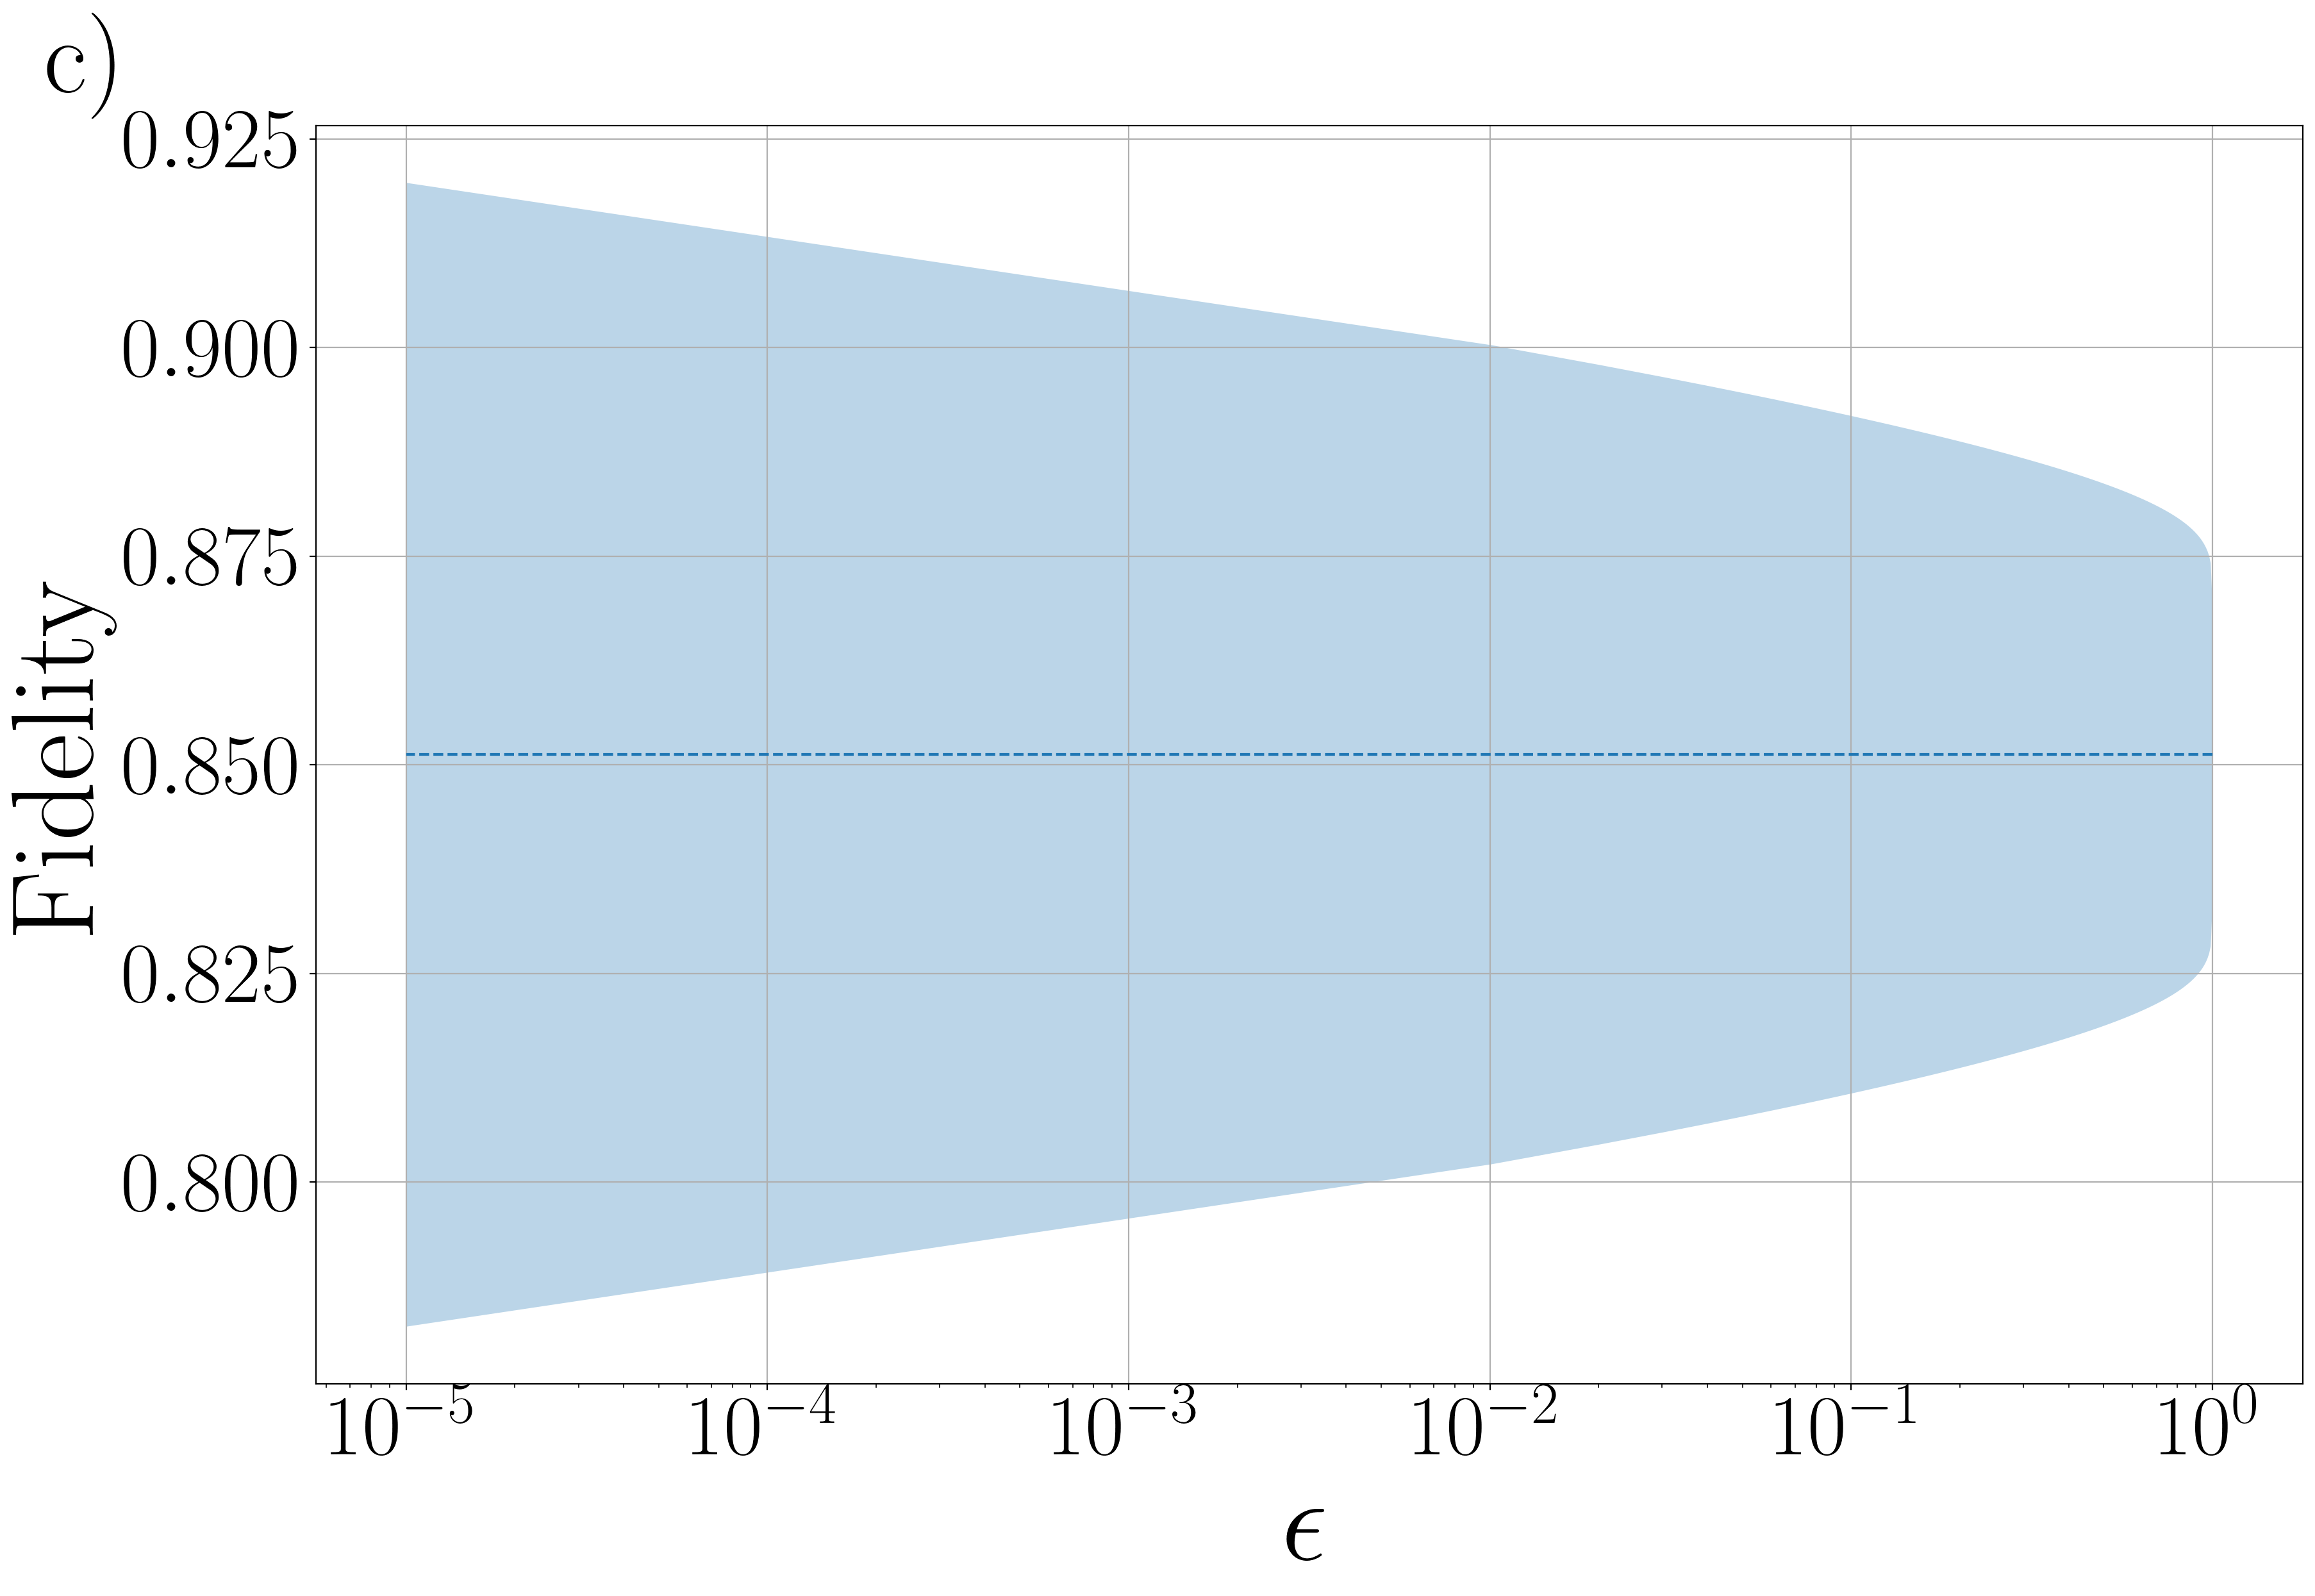

In [13]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.xscale('log')
plt.plot([epsilons[0], epsilons[-1]], [fidelity] * 2, '--')
plt.figtext(0.02, 0.9, "c)")
plt.savefig('../imgs/polytope/fig2c.pdf')